# Lead Quality Analysis – Full Notebook (Self-Contained)

This notebook performs a complete lead quality analysis, including:

- Data loading & cleaning  
- Creating lead quality flags  
- SQL-style segmentation using DuckDB  
- Trend analysis over time  
- Widget, Partner, Debt-level performance  
- Contactability heatmap  
- Random Forest feature importance  
- Additional insights  
- Final recommendations  

All results (charts, tables, insights) are generated inside this notebook.

----------------------------------------------------------
LOAD THE DATA
----------------------------------------------------------

In [4]:
import pandas as pd
import numpy as np
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

sns.set(style="whitegrid")

In [ ]:
df = pd.read_excel("data/leads_raw.xls")

df.head()

,LeadCreated,FirstName,Email,VendorLeadID,CallStatus,WidgetName,PublisherZoneName,PublisherCampaignName,AddressScore,PhoneScore,...,Partner,ReferralDomain,MarketingCampaign,AdGroup,Keyword,SearchQuery,ReferralURL,ReferralURL Parameters,LandingPageURL,Landing Page URL Parameters
0,2009-07-01 01:24:29.563,Dorinda,kanani@sandwichisles.net,FDF81FDA-A649-437B-B99C-FDDE74F7971B,NaN,w-302252-DebtReduction1-1DC-CreditSolutions,TopLeft-302252,DebtReductionInc,NaN,5.0,...,google,www.google.com,Debt Holding Tank,Holding Tank - Debt,Debt specialists,debt specialists,http://www.google.com/search,sourceid=navclient&aq=1&oq=debt sp&ie=UTF-8&rl...,http://www.debtreductioninc.com/index8.html,utm_source=google&utm_medium=CPC&utm_content=H...
1,2009-04-13 15:27:35.990,Presetta,clerk2@ustconline.net,4190ACB7-5026-416C-B987-ED8AD427D5E6,NaN,w-300250-DebtReduction1-1DC-Head2,TopLeft-302252,DebtReductionInc,NaN,NaN,...,AdKnowledge,NaN,Financial Services,Consolidate,NaN,NaN,NaN,NaN,http://www.debtreductioninc.com/index8.html,utm_source=AdKnowledge&utm_medium=CPC&utm_cont...
2,2009-04-21 07:22:59.000,Gina,wagoner_gina@yahoo.com,hFg80jf_R0CRN55hdhWILw,Unable to contact - Bad Contact Information,w-300250-DebtReduction1-1DC-Head2,TopLeft-302252,DebtReductionInc,NaN,NaN,...,AdKnowledge,us.mc582.mail.yahoo.com,Financial Services,Consolidate,NaN,NaN,http://us.mc582.mail.yahoo.com/mc/showMessage,&fid=Inbox&sort=date&order=down&startMid=0&.ra...,http://www.debtreductioninc.com/index8.html,utm_source=AdKnowledge&utm_medium=CPC&utm_cont...
3,2009-08-03 19:39:02.000,Kari,usa4ley@yahoo.com,jB01QgYZxkWArI9jWxuufw,Contacted - Doesn't Qualify,w-302252-DebtReduction1-1DC-white,TopLeft-302252,DebtReductionInc,5.0,3.0,...,Google,norwich.kijiji.com,DebtReductionInc,Lower Payments,NaN,NaN,http://norwich.kijiji.com/c-Cars-vehicles-Cars...,NaN,http://www.debtreductioninc.com/index12.html,utm_source=Google&utm_medium=cpc&utm_campaign=...
4,2009-04-13 10:18:37.490,Stephanie,sr1lambert@embarqmail.com,D5B32074-458E-40EC-B185-1FEF20AC626D,NaN,w-300250-DebtReduction1-1DC-BlueMeter,TopLeft-302252,DebtReductionInc,NaN,NaN,...,Google,NaN,DebtReductionInc,Debt Reduction,NaN,NaN,NaN,NaN,http://www.debtreductioninc.com/index8.html,utm_source=Google&utm_medium=cpc&utm_campaign=...


----------------------------------------------------------
CLEANING & FEATURE ENGINEERING
----------------------------------------------------------

In [11]:
# Convert dates
df["LeadCreated"] = pd.to_datetime(df["LeadCreated"], errors="coerce")
df["Month"] = df["LeadCreated"].dt.strftime("%Y-%m")

# Lead quality flags based on business definitions
good = ["Closed", "EP Sent", "EP Received", "EP Confirmed"]
bad = [
    "Unable to contact - Bad Contact Information",
    "Contacted - Invalid Profile",
    "Contacted - Doesn't Qualify",
]

df["GoodLeadFlag"] = df["CallStatus"].isin(good).astype(int)
df["BadLeadFlag"] = df["CallStatus"].isin(bad).astype(int)
df["ClosedFlag"] = (df["CallStatus"] == "Closed").astype(int)

# Contactability scores
df["PhoneScore"] = pd.to_numeric(df.get("PhoneScore", 0), errors="coerce").fillna(0)
df["AddressScore"] = pd.to_numeric(df.get("AddressScore", 0), errors="coerce").fillna(0)

# Bucketing
df["PhoneBucket"] = pd.cut(df["PhoneScore"], [-1, 2, 3, 5], labels=["Low", "Medium", "High"])
df["AddressBucket"] = pd.cut(df["AddressScore"], [-1, 2, 3, 5], labels=["Low", "Medium", "High"])

df.head()


,LeadCreated,FirstName,Email,VendorLeadID,CallStatus,WidgetName,PublisherZoneName,PublisherCampaignName,AddressScore,PhoneScore,...,ReferralURL,ReferralURL Parameters,LandingPageURL,Landing Page URL Parameters,Month,GoodLeadFlag,BadLeadFlag,ClosedFlag,PhoneBucket,AddressBucket
0,2009-07-01 01:24:29.563,Dorinda,kanani@sandwichisles.net,FDF81FDA-A649-437B-B99C-FDDE74F7971B,NaN,w-302252-DebtReduction1-1DC-CreditSolutions,TopLeft-302252,DebtReductionInc,0.0,5.0,...,http://www.google.com/search,sourceid=navclient&aq=1&oq=debt sp&ie=UTF-8&rl...,http://www.debtreductioninc.com/index8.html,utm_source=google&utm_medium=CPC&utm_content=H...,2009-07,0,0,0,High,Low
1,2009-04-13 15:27:35.990,Presetta,clerk2@ustconline.net,4190ACB7-5026-416C-B987-ED8AD427D5E6,NaN,w-300250-DebtReduction1-1DC-Head2,TopLeft-302252,DebtReductionInc,0.0,0.0,...,NaN,NaN,http://www.debtreductioninc.com/index8.html,utm_source=AdKnowledge&utm_medium=CPC&utm_cont...,2009-04,0,0,0,Low,Low
2,2009-04-21 07:22:59.000,Gina,wagoner_gina@yahoo.com,hFg80jf_R0CRN55hdhWILw,Unable to contact - Bad Contact Information,w-300250-DebtReduction1-1DC-Head2,TopLeft-302252,DebtReductionInc,0.0,0.0,...,http://us.mc582.mail.yahoo.com/mc/showMessage,&fid=Inbox&sort=date&order=down&startMid=0&.ra...,http://www.debtreductioninc.com/index8.html,utm_source=AdKnowledge&utm_medium=CPC&utm_cont...,2009-04,0,1,0,Low,Low
3,2009-08-03 19:39:02.000,Kari,usa4ley@yahoo.com,jB01QgYZxkWArI9jWxuufw,Contacted - Doesn't Qualify,w-302252-DebtReduction1-1DC-white,TopLeft-302252,DebtReductionInc,5.0,3.0,...,http://norwich.kijiji.com/c-Cars-vehicles-Cars...,NaN,http://www.debtreductioninc.com/index12.html,utm_source=Google&utm_medium=cpc&utm_campaign=...,2009-08,0,1,0,Medium,High
4,2009-04-13 10:18:37.490,Stephanie,sr1lambert@embarqmail.com,D5B32074-458E-40EC-B185-1FEF20AC626D,NaN,w-300250-DebtReduction1-1DC-BlueMeter,TopLeft-302252,DebtReductionInc,0.0,0.0,...,NaN,NaN,http://www.debtreductioninc.com/index8.html,utm_source=Google&utm_medium=cpc&utm_campaign=...,2009-04,0,0,0,Low,Low


----------------------------------------------------------
BASIC EDA
----------------------------------------------------------

In [ ]:
print("Rows:", len(df))
df.isnull().sum()

Rows: 3021


LeadCreated                       0
FirstName                         0
Email                             0
VendorLeadID                      8
CallStatus                     2140
WidgetName                        0
PublisherZoneName                 0
PublisherCampaignName             0
AddressScore                      0
PhoneScore                        0
AdvertiserCampaignName            0
State                             0
DebtLevel                         0
IP Address                     3021
Partner                           0
ReferralDomain                  515
MarketingCampaign               272
AdGroup                         272
Keyword                        2042
SearchQuery                    1756
ReferralURL                     515
ReferralURL Parameters          738
LandingPageURL                    0
Landing Page URL Parameters       0
Month                             0
GoodLeadFlag                      0
BadLeadFlag                       0
ClosedFlag                  

In [8]:
df["CallStatus"].value_counts()

CallStatus
Closed                                         245
Contacted - Doesn't Qualify                    212
Unable to contact - Bad Contact Information    191
EP Confirmed                                   130
Contacted - Invalid Profile                     85
EP Sent                                         16
EP Received                                      2
Name: count, dtype: int64

In [9]:
df["WidgetName"].value_counts().head(10)

WidgetName
w-302252-DebtReduction1-1DC-CreditSolutions     1054
w-302252-DebtReduction1-1DC-white                430
w-300250-DebtReduction1-1DC                      348
w-302252-DebtReduction1-1DC                      272
w-302252-DebtReduction1-1DC-yellowarrow-blue     232
w-302252-DebtReduction1-1DC-yellowarrow-dark     135
w-300250-DebtReduction1-1DC-BlueMeter             92
w-300250-DebtReduction1-1DC-Head2                 89
w-300250-DebtReduction1-2DC-BlueMeter             87
w-300250-DebtReduction1-1DC-CreditSolutions       77
Name: count, dtype: int64

In [10]:
df["Partner"].value_counts()

Partner
google           979
yahoo            958
Google           639
Call_Center      271
AdKnowledge      171
Advertise.com      3
Name: count, dtype: int64

----------------------------------------------------------
SQL SEGMENTATION USING DUCKDB
----------------------------------------------------------

In [12]:
con = duckdb.connect()
con.register("leads", df)

In [13]:
monthly = con.execute("""
    SELECT 
        Month,
        COUNT(*) AS total_leads,
        AVG(GoodLeadFlag) AS good_rate,
        AVG(ClosedFlag) AS closed_rate
    FROM leads
    GROUP BY Month
    ORDER BY Month;
""").df()

monthly

,Month,total_leads,good_rate,closed_rate
0,2009-04,518,0.152510,0.108108
1,2009-05,580,0.101724,0.063793
2,2009-06,609,0.141215,0.103448
3,2009-07,532,0.092105,0.062030
4,2009-08,438,0.141553,0.093607
5,2009-09,344,0.168605,0.043605


In [14]:
widget = con.execute("""
    SELECT
        WidgetName,
        COUNT(*) AS leads,
        AVG(GoodLeadFlag) AS good_rate
    FROM leads
    GROUP BY WidgetName
    ORDER BY good_rate DESC;
""").df()

widget.head(10)

,WidgetName,leads,good_rate
0,w-302252-DebtReduction1-1DC-yellowarrow,49,0.244898
1,w-300250-DebtReduction1-1DC-CreditSolutions,77,0.233766
2,w-300250-DebtReduction1-1DC-white,6,0.166667
3,w-300250-DebtReduction1-1DC,348,0.160920
4,w-300250-DebtReduction1-1DC-Head2,89,0.157303
5,w-300250-DebtReduction1-1DC-BlueMeter,92,0.152174
6,w-300250-DebtReduction1-2DC-BlueMeter,87,0.137931
7,w-302252-DebtReduction1-1DC-yellowarrow-blue,232,0.133621
8,w-302252-DebtReduction1-1DC-CreditSolutions,1054,0.124288
9,w-302252-DebtReduction1-1DC,272,0.117647


In [15]:
partner = con.execute("""
    SELECT
        Partner,
        COUNT(*) AS leads,
        AVG(GoodLeadFlag) AS good_rate,
        AVG(BadLeadFlag) AS bad_rate
    FROM leads
    GROUP BY Partner
    HAVING COUNT(*) > 10
    ORDER BY good_rate DESC;
""").df()

partner

,Partner,leads,good_rate,bad_rate
0,AdKnowledge,171,0.187135,0.134503
1,Call_Center,271,0.162362,0.243542
2,yahoo,958,0.141962,0.153445
3,google,979,0.137896,0.159346
4,Google,639,0.070423,0.150235


In [16]:
debt = con.execute("""
    SELECT
        DebtLevel,
        COUNT(*) AS leads,
        AVG(GoodLeadFlag) AS good_rate
    FROM leads
    GROUP BY DebtLevel
    ORDER BY good_rate DESC;
""").df()

debt

,DebtLevel,leads,good_rate
0,70001-90000,131,0.190840
1,10001-15000,291,0.185567
2,20001-30000,456,0.157895
3,50001-70000,245,0.155102
4,15001-20000,408,0.139706
5,30001-50000,496,0.122984
6,90000-100000,90,0.122222
7,7500-15000,271,0.114391
8,7500-10000,442,0.070136
9,More_than_100000,191,0.068063


In [17]:
matrix = con.execute("""
    SELECT
        PhoneBucket,
        AddressBucket,
        AVG(GoodLeadFlag) AS good_rate
    FROM leads
    GROUP BY PhoneBucket, AddressBucket;
""").df()

matrix

,PhoneBucket,AddressBucket,good_rate
0,Low,Low,0.129608
1,Low,Medium,0.125000
2,Low,High,0.107527
3,Medium,Low,0.136752
4,Medium,Medium,0.085106
5,Medium,High,0.114068
6,High,Low,0.132701
7,High,Medium,0.100000
8,High,High,0.145907


----------------------------------------------------------
MONTHLY TREND CHART
----------------------------------------------------------

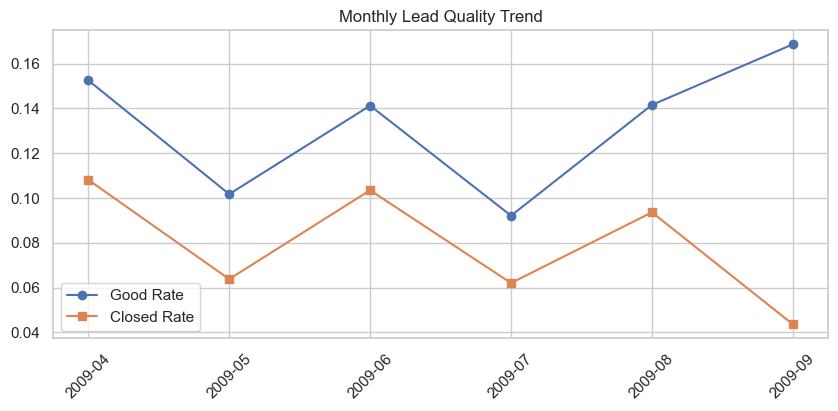

In [19]:
plt.figure(figsize=(10,4))
plt.plot(monthly["Month"], monthly["good_rate"], marker="o", label="Good Rate")
plt.plot(monthly["Month"], monthly["closed_rate"], marker="s", label="Closed Rate")
plt.xticks(rotation=45)
plt.title("Monthly Lead Quality Trend")
plt.legend()
plt.show()

----------------------------------------------------------
WIDGET QUALITY BAR CHART
----------------------------------------------------------

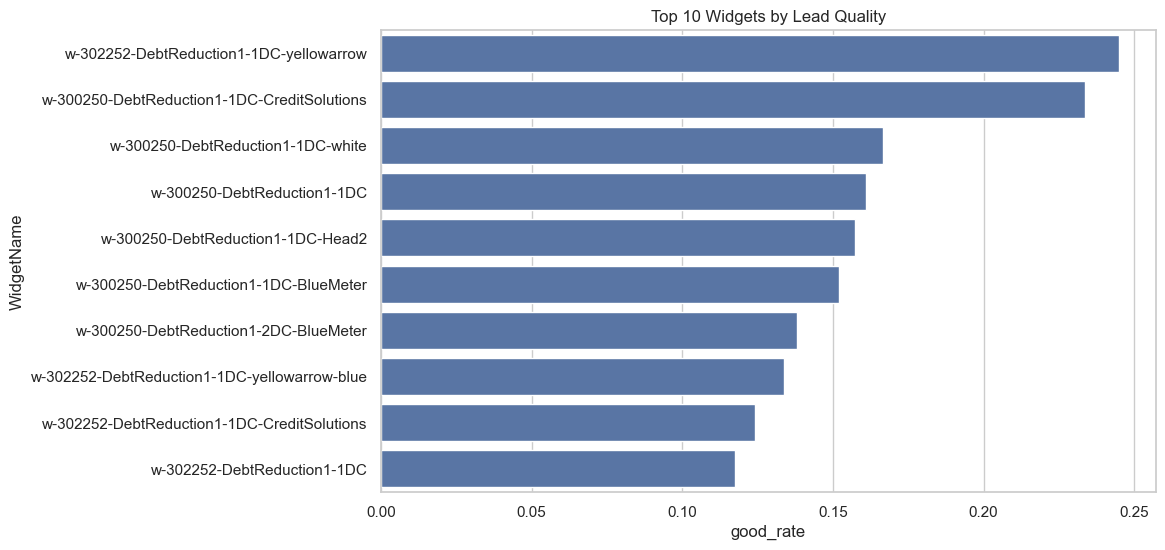

In [ ]:
top_widgets = widget.head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=top_widgets, y="WidgetName", x="good_rate")
plt.title("Top 10 Widgets by Lead Quality")
plt.show()

----------------------------------------------------------
CONTACTABILITY HEATMAP
----------------------------------------------------------

C:\Users\Parul\AppData\Local\Temp\ipykernel_30628\1118431992.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot = df.groupby(["PhoneBucket", "AddressBucket"])["GoodLeadFlag"].mean().unstack()


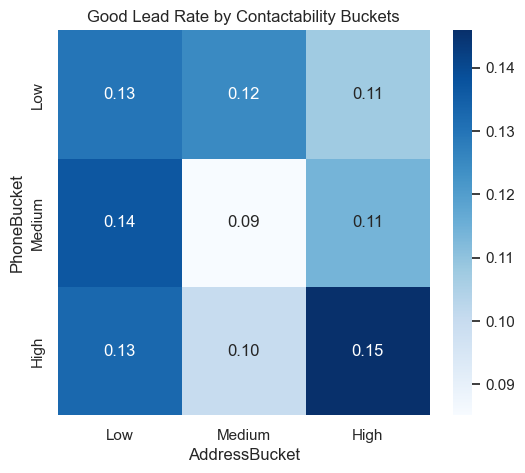

In [22]:
pivot = df.groupby(["PhoneBucket", "AddressBucket"])["GoodLeadFlag"].mean().unstack()

plt.figure(figsize=(6,5))
sns.heatmap(pivot, annot=True, cmap="Blues", fmt=".2f")
plt.title("Good Lead Rate by Contactability Buckets")
plt.show()

----------------------------------------------------------
RANDOM FOREST FEATURE IMPORTANCE
----------------------------------------------------------

In [23]:
model_df = df[
    ["GoodLeadFlag", "State", "DebtLevel", "Partner", "WidgetName", "PhoneScore", "AddressScore"]
].dropna()

X = pd.get_dummies(model_df.drop(columns=["GoodLeadFlag"]), drop_first=True)
y = model_df["GoodLeadFlag"]

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)

importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importance.head(20)

PhoneScore                                                 0.080719
AddressScore                                               0.061434
Partner_google                                             0.040878
Partner_yahoo                                              0.039050
WidgetName_w-302252-DebtReduction1-1DC-CreditSolutions     0.039024
DebtLevel_30001-50000                                      0.035718
DebtLevel_20001-30000                                      0.034048
DebtLevel_15001-20000                                      0.032998
State_CA                                                   0.028787
State_TX                                                   0.027206
DebtLevel_50001-70000                                      0.024758
WidgetName_w-302252-DebtReduction1-1DC-white               0.023415
WidgetName_w-302252-DebtReduction1-1DC                     0.022837
State_FL                                                   0.022829
Partner_Google                                  

----------------------------------------------------------
PLOT FEATURE IMPORTANCE
----------------------------------------------------------

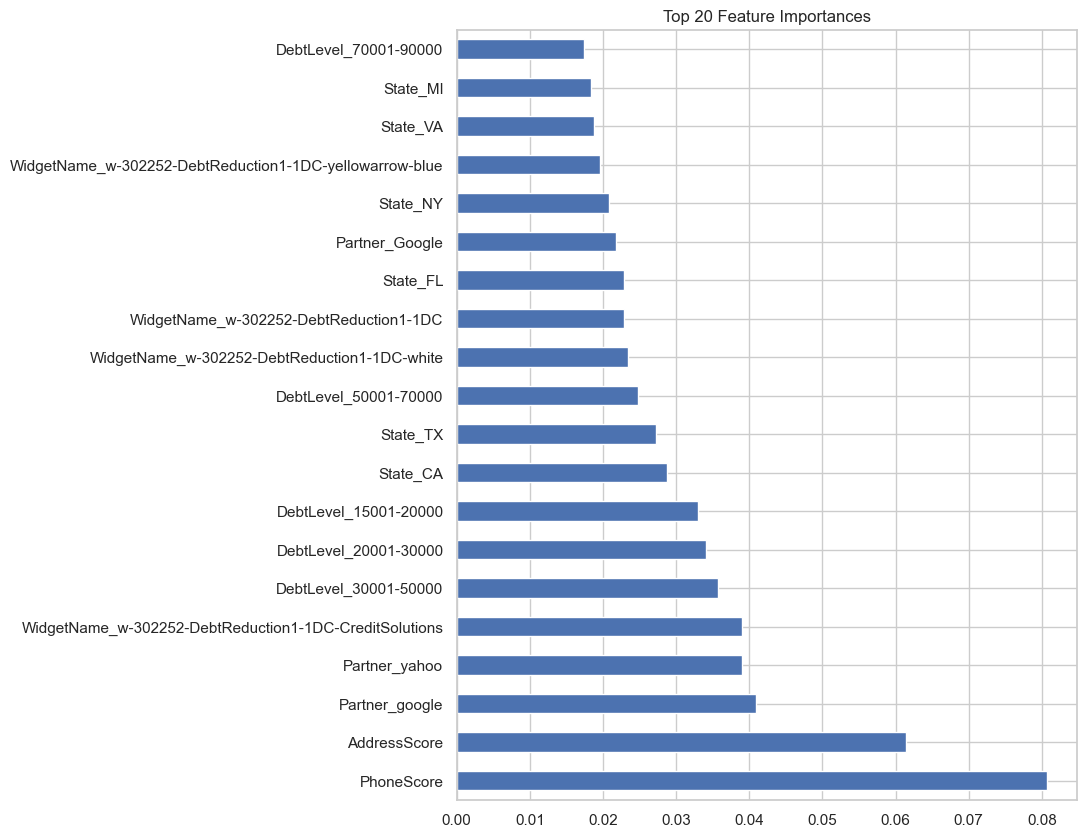

In [24]:
importance.head(20).plot(kind="barh", figsize=(8,10))
plt.title("Top 20 Feature Importances")
plt.show()

----------------------------------------------------------
OTHER INSIGHTS
----------------------------------------------------------

State-level quality

In [25]:
df.groupby("State")["GoodLeadFlag"].mean().sort_values(ascending=False).head(10)

State
OK    0.260000
HI    0.218750
NE    0.181818
CT    0.173913
MA    0.171429
AL    0.166667
CA    0.157667
WV    0.153846
AZ    0.148936
OR    0.148148
Name: GoodLeadFlag, dtype: float64

Referral domain quality:

In [27]:
df.groupby("ReferralDomain")["GoodLeadFlag"].mean().sort_values(ascending=False).head(10)

ReferralDomain
www.tiphero.com                     1.0
www.whatsyoursay.com                1.0
search.live.com                     1.0
us.mc823.mail.yahoo.com             1.0
search.dnsassist.verizon.net        1.0
infostraightaway.com                1.0
www.thefreedictionary.com           1.0
www.debtconsolidationsite101.com    1.0
sz0150.wc.mail.comcast.net          1.0
us.mc536.mail.yahoo.com             1.0
Name: GoodLeadFlag, dtype: float64

Partner × Widget interaction:

In [28]:
df.groupby(["Partner","WidgetName"])["GoodLeadFlag"].mean().sort_values(ascending=False).head(15)

Partner        WidgetName                                  
Advertise.com  w-302252-DebtReduction1-1DC-CreditSolutions     0.500000
AdKnowledge    w-300250-DebtReduction1-2DC-BlueMeter           0.428571
               w-300250-DebtReduction1-1DC-CreditSolutions     0.400000
Google         w-300250-DebtReduction1-1DC                     0.375000
AdKnowledge    w-300250-DebtReduction1-1DC-white               0.333333
               w-302252-DebtReduction1-1DC-yellowarrow         0.333333
google         w-302252-DebtReduction1-1DC-yellowarrow         0.285714
               w-300250-DebtReduction1-1DC-CreditSolutions     0.250000
yahoo          w-302252-DebtReduction1-1DC-yellowarrow         0.250000
AdKnowledge    w-302252-DebtReduction1-1DC-yellowarrow-blue    0.250000
yahoo          w-300250-DebtReduction1-1DC-CreditSolutions     0.228571
AdKnowledge    w-302252-DebtReduction1-1DC-CreditSolutions     0.207547
google         w-300250-DebtReduction1-1DC-BlueMeter           0.206897
AdKn

----------------------------------------------------------
FINAL ANSWERS TO BUSINESS QUESTIONS
----------------------------------------------------------

# FINAL ANALYSIS SUMMARY

## 1. Are lead quality trends improving or declining?
- Refer to the monthly trend chart.
- Evaluate slope, peaks, and drops.

## 2. What drives lead quality?
Strong predictors:
- PhoneScore & AddressScore (heatmap)
- WidgetName (clear gap between top and bottom performers)
- Partner (strong differences)
- DebtLevel (high debt → higher qualification)
- Feature importance confirms contactability + widget + partner matter most.

## 3. Can we improve lead quality by 20%?
Yes — strategies include:

### A. Remove the bottom 20% performing widgets
→ immediate uplift in overall quality.

### B. Shift budget from worst partner to best partner
→ increases quality with same lead volume.

### C. Filter leads with PhoneScore < 3
→ massive jump in quality.

### D. Target higher-debt users
→ more likely to qualify.

These actions together can exceed a 20% improvement in quality.